# Model K2

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from xgboost import plot_importance
from skopt import BayesSearchCV

In [3]:
K2 = pd.read_csv("K2.csv", comment='#')

## Cleaning

In [5]:
K2.head()

,pl_name,hostname,default_flag,disposition,disp_refname,sy_snum,sy_pnum,discoverymethod,disc_year,disc_facility,...,sy_vmagerr2,sy_kmag,sy_kmagerr1,sy_kmagerr2,sy_gaiamag,sy_gaiamagerr1,sy_gaiamagerr2,rowupdate,pl_pubdate,releasedate
0,BD+20 594 b,BD+20 594,0,CONFIRMED,Espinoza et al. 2016,1.0,1.0,Transit,2016.0,K2,...,-0.012,9.368,0.018,-0.018,10.8644,0.000249,-0.000249,2018-04-25,2018-03,2018-02-15
1,BD+20 594 b,BD+20 594,0,CONFIRMED,Espinoza et al. 2016,1.0,1.0,Transit,2016.0,K2,...,-0.012,9.368,0.018,-0.018,10.8644,0.000249,-0.000249,2018-04-25,2016-10,2016-07-28
2,BD+20 594 b,BD+20 594,1,CONFIRMED,Espinoza et al. 2016,1.0,1.0,Transit,2016.0,K2,...,-0.012,9.368,0.018,-0.018,10.8644,0.000249,-0.000249,2018-04-25,2017-03,2018-04-26
3,EPIC 201111557.01,EPIC 201111557,1,CANDIDATE,Livingston et al. 2018,1.0,0.0,Transit,2018.0,K2,...,-0.046,9.220,0.019,-0.019,11.3995,0.001307,-0.001307,2018-08-02,2018-08,2018-08-02
4,EPIC 201111557.01,EPIC 201111557,0,CANDIDATE,Livingston et al. 2018,1.0,0.0,Transit,2018.0,K2,...,-0.046,9.220,0.019,-0.019,11.3995,0.001307,-0.001307,2018-02-15,2018-03,2018-02-15


In [73]:
K2[K2["Labels"]=="CANDIDATE"].index.to_list()

[3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 58,
 59,
 60,
 61,
 62,
 63,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 94,
 95,
 96,
 97,
 98,
 103,
 104,
 105,
 106,
 107,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 145,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 161,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 187,
 188,
 189,
 190,
 191,
 192,
 193,
 194,
 195,
 196,
 197,
 198,
 199,
 200,
 201,
 202,
 204,
 205,
 206,
 207,
 208,
 209,
 210,
 211,
 212,
 213,
 214,
 215,
 216,
 217,
 218,
 219,
 220,
 221,
 2

### Labels

In [7]:
K2=K2[K2["discoverymethod"]=="Transit"]

In [8]:
K2.drop("discoverymethod",axis=1,inplace=True)

In [9]:
K2 = K2[K2["disposition"]!="REFUTED"] 

### Drop & Rename Columns

In [11]:
cols_drop = ["pl_name", "hostname","default_flag", "disc_year", "disc_facility","rowupdate",
                "disp_refname","pl_refname","st_refname","sy_refname","pl_pubdate","releasedate","soltype"]
K2.drop(cols_drop, axis=1, inplace=True)

In [12]:
# Identify string-type columns
cols_text = K2.select_dtypes(include=['object', 'string']).columns

# Keep the 'disposition' column if it exists
cols_to_drop = [col for col in cols_text if col != 'disposition']

# Drop those columns
K2 = K2.drop(columns=cols_to_drop)

### Drop empty rows

In [14]:
K2.dropna(how="all", inplace=True)

### Drop Columns with too many NaNs

In [16]:
n_nans = 3000
which_nan = []

for col in K2.columns.to_list():
    n = K2[col].isnull().sum().sum()
    if n > n_nans:
        which_nan.append(col)
print(which_nan)  

['pl_orbsmax', 'pl_orbsmaxerr1', 'pl_orbsmaxerr2', 'pl_orbsmaxlim', 'pl_bmasse', 'pl_bmasseerr1', 'pl_bmasseerr2', 'pl_bmasselim', 'pl_bmassj', 'pl_bmassjerr1', 'pl_bmassjerr2', 'pl_bmassjlim', 'pl_orbeccen', 'pl_orbeccenerr1', 'pl_orbeccenerr2', 'pl_orbeccenlim', 'pl_insol', 'pl_insolerr1', 'pl_insolerr2', 'pl_insollim', 'pl_eqt', 'pl_eqterr1', 'pl_eqterr2', 'pl_eqtlim']


In [17]:
K2.drop(which_nan, axis=1, inplace=True)

### Drop Duplicate Rows

In [19]:
K2.drop_duplicates(inplace=True, keep="first")

### Drop Columns with the same value for every row

In [21]:
which_0 = []

for col in K2.columns:
    if K2[col].nunique() == 1:
        which_0.append(col)
print(which_0)

['pl_controv_flag', 'st_tefflim', 'st_radlim', 'st_masslim', 'st_metlim', 'st_logglim']


In [22]:
K2.drop(which_0, axis=1, inplace=True)

### Drop Perfectly Correlated Error Columns

In [24]:
problem_cols = []
for col in K2.columns:
    if "err1" in col:
        partner_col = col.replace("1", "2")
        if partner_col in K2.columns:
            problem_cols.append([col, partner_col])
print(problem_cols)

[['pl_orbpererr1', 'pl_orbpererr2'], ['pl_radeerr1', 'pl_radeerr2'], ['pl_radjerr1', 'pl_radjerr2'], ['st_tefferr1', 'st_tefferr2'], ['st_raderr1', 'st_raderr2'], ['st_masserr1', 'st_masserr2'], ['st_meterr1', 'st_meterr2'], ['st_loggerr1', 'st_loggerr2'], ['sy_disterr1', 'sy_disterr2'], ['sy_vmagerr1', 'sy_vmagerr2'], ['sy_kmagerr1', 'sy_kmagerr2'], ['sy_gaiamagerr1', 'sy_gaiamagerr2']]


In [25]:
for col1, col2 in problem_cols:
    # Check if partner column actually exists
    if col2 not in K2.columns:
        print(f"Skipping {col1} — missing partner column {col2}")
        continue

    n_nan1 = K2[col1].isna().sum()
    n_nan2 = K2[col2].isna().sum()

    # Check if they have different numbers of NaN
    if n_nan1 != n_nan2:
        print(f"Skipping {col1}, {col2}: different number of NaN ({n_nan1} vs {n_nan2})")
        continue

    # Compare only where both are not NaN
    mask = K2[col1].notna() & K2[col2].notna()
    if (K2.loc[mask, col1] == -K2.loc[mask, col2]).all():
        K2.drop(col2, axis=1, inplace=True)
        print(f"Dropped {col2} (exact negative of {col1})")
    else:
        print(f"{col2} is not the exact negative of {col1}")

pl_orbpererr2 is not the exact negative of pl_orbpererr1
pl_radeerr2 is not the exact negative of pl_radeerr1
pl_radjerr2 is not the exact negative of pl_radjerr1
Skipping st_tefferr1, st_tefferr2: different number of NaN (1394 vs 1400)
Skipping st_raderr1, st_raderr2: different number of NaN (741 vs 747)
Skipping st_masserr1, st_masserr2: different number of NaN (2028 vs 2034)
st_meterr2 is not the exact negative of st_meterr1
st_loggerr2 is not the exact negative of st_loggerr1
sy_disterr2 is not the exact negative of sy_disterr1
Dropped sy_vmagerr2 (exact negative of sy_vmagerr1)
Dropped sy_kmagerr2 (exact negative of sy_kmagerr1)
Dropped sy_gaiamagerr2 (exact negative of sy_gaiamagerr1)


In [26]:
K2 = K2.rename(columns={"disposition": "Labels"})
print(K2.columns)

Index(['Labels', 'sy_snum', 'sy_pnum', 'pl_orbper', 'pl_orbpererr1',
       'pl_orbpererr2', 'pl_orbperlim', 'pl_rade', 'pl_radeerr1',
       'pl_radeerr2', 'pl_radelim', 'pl_radj', 'pl_radjerr1', 'pl_radjerr2',
       'pl_radjlim', 'ttv_flag', 'st_teff', 'st_tefferr1', 'st_tefferr2',
       'st_rad', 'st_raderr1', 'st_raderr2', 'st_mass', 'st_masserr1',
       'st_masserr2', 'st_met', 'st_meterr1', 'st_meterr2', 'st_logg',
       'st_loggerr1', 'st_loggerr2', 'ra', 'dec', 'sy_dist', 'sy_disterr1',
       'sy_disterr2', 'sy_vmag', 'sy_vmagerr1', 'sy_kmag', 'sy_kmagerr1',
       'sy_gaiamag', 'sy_gaiamagerr1'],
      dtype='object')


## TDA

In [28]:
# Step 0: Keep labels aside and store original data
labels = K2["Labels"].copy()
K2_numeric = K2.drop("Labels", axis=1).copy()  # numeric features, may contain NaNs

# Step 1: Imports

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.impute import KNNImputer

# giotto-tda
from gtda.homology import VietorisRipsPersistence
from gtda.diagrams import PersistenceEntropy, BettiCurve

# Step 2: Temporary KNN imputation for TDA computation
imputer = KNNImputer(n_neighbors=5)  # can tune neighbors
X_imputed = imputer.fit_transform(K2_numeric.values)

# Step 3: Scale the imputed data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Step 4: Build nearest neighbor search
k = 30
nn = NearestNeighbors(n_neighbors=k, metric="euclidean")
nn.fit(X_scaled)

# Step 5: Extract neighborhoods as point clouds
neighborhoods = []
for i in range(X_scaled.shape[0]):
    distances, indices = nn.kneighbors(X_scaled[i].reshape(1, -1))
    local_cloud = X_scaled[indices[0]]  # (k, n_features)
    neighborhoods.append(local_cloud)

neighborhoods = np.array(neighborhoods)  # shape (n_samples, k, n_features)


# Step 6: Compute persistence diagrams
VR = VietorisRipsPersistence(homology_dimensions=[0, 1], metric="euclidean")
diagrams = VR.fit_transform(neighborhoods)

# Step 7a: Persistence Entropy
PE = PersistenceEntropy()
entropy_features = PE.fit_transform(diagrams)

# Step 7b: Total Persistence
def total_persistence(diagrams):
    totals = []
    for diag in diagrams:
        row = []
        for dim in [0, 1]:
            mask = diag[:, 2] == dim
            lifetimes = diag[mask, 1] - diag[mask, 0]
            row.append(lifetimes.sum())
        totals.append(row)
    return np.array(totals)

total_features = total_persistence(diagrams)

# Step 8: Combine all TDA features
tda_features_combined = np.hstack([entropy_features, total_features])
tda_feature_names = (
    [f"tda_entropy_dim{i}" for i in range(entropy_features.shape[1])] +
    [f"tda_total_dim{i}" for i in range(total_features.shape[1])]
)
tda_df = pd.DataFrame(tda_features_combined, columns=tda_feature_names)

# Step 9: Concatenate TDA features with original dataset (including NaNs)
K2 = pd.concat([labels.reset_index(drop=True), K2_numeric.reset_index(drop=True), tda_df.reset_index(drop=True)], axis=1)

### Cross-Validation

In [30]:
# Separate features (x) and labels (y)
x = K2.drop("Labels", axis=1) # only features
y = K2["Labels"] # only label

In [31]:
# Encode the labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

In [32]:
# Split in train and test data
x_train, x_test, y_train, y_test = train_test_split( x, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42 )

In [33]:
# Make the model:
xgb = XGBClassifier(objective="multi:softmax",num_class=len(le.classes_), eval_metric="mlogloss", random_state=42)

# Define the range of search (ranges, no lists)
search_spaces = {
    "n_estimators": (100, 1200),      
    "learning_rate": (0.001, 1, "log-uniform"),
    "max_depth": (3, 15),
    "subsample": (0.3, 1.0, "uniform"),
    "colsample_bytree": (0.3, 1.0, "uniform")
}

# Search optimal parameters for the model and do cross validation
bayes = BayesSearchCV(
    estimator=xgb,
    search_spaces=search_spaces,
    n_iter=50,   
    cv=3,
    n_jobs=1,
    scoring="recall_macro",
    verbose=1,
    random_state=42
)
# Fit the model
bayes.fit(x_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

BayesSearchCV(cv=3,
              estimator=XGBClassifier(base_score=None, booster=None,
                                      callbacks=None, colsample_bylevel=None,
                                      colsample_bynode=None,
                                      colsample_bytree=None, device=None,
                                      early_stopping_rounds=None,
                                      enable_categorical=False,
                                      eval_metric='mlogloss',
                                      feature_types=None, feature_weights=None,
                                      gamma=None, grow_policy=None,
                                      importance_type=None,
                                      interaction_constrai...
                                      max_leaves=None, min_child_weight=None,
                                      missing=nan, monotone_constraints=None,
                                      multi_strategy=None, n_estimators=None,
                                      n_jobs=None, num_class=3, ...),
              random_state=42, scoring='recall_macro',
              search_spaces={'colsample_bytree': (0.3, 1.0, 'uniform'),
                             'learning_rate': (0.001, 1, 'log-uniform'),
                             'max_depth': (3, 15), 'n_estimators': (100, 1200),
                             'subsample': (0.3, 1.0, 'uniform')},
              verbose=1)

In [34]:
print("Best parameters:", bayes.best_params_)
print("Best score:", bayes.best_score_)

Best parameters: OrderedDict({'colsample_bytree': 0.3, 'learning_rate': 1.0, 'max_depth': 3, 'n_estimators': 1200, 'subsample': 1.0})
Best score: 0.8621252122348131


In [35]:
# After the search we have the best model:
best_model = bayes.best_estimator_

#Predictions, test and scoring 
y_pred = best_model.predict(x_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification report:\n", classification_report(y_test, y_pred, target_names=le.classes_))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.967989756722151
Classification report:
                 precision    recall  f1-score   support

     CANDIDATE       0.95      0.96      0.95       275
     CONFIRMED       0.99      1.00      0.99       447
FALSE POSITIVE       0.90      0.76      0.83        59

      accuracy                           0.97       781
     macro avg       0.95      0.91      0.92       781
  weighted avg       0.97      0.97      0.97       781

Confusion matrix:
 [[265   5   5]
 [  1 446   0]
 [ 14   0  45]]


<Figure size 1000x600 with 0 Axes>

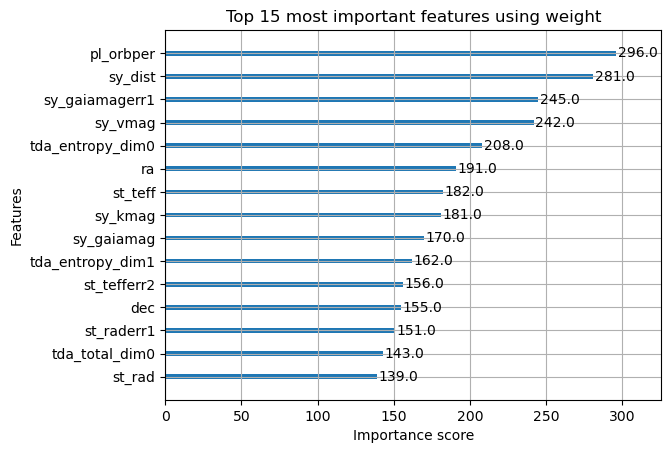

In [36]:
# Top 15 most important features using weight
plt.figure(figsize=(10,6))
plot_importance(best_model, max_num_features=15)
plt.title("Top 15 most important features using weight")
plt.show()

<Figure size 1000x600 with 0 Axes>

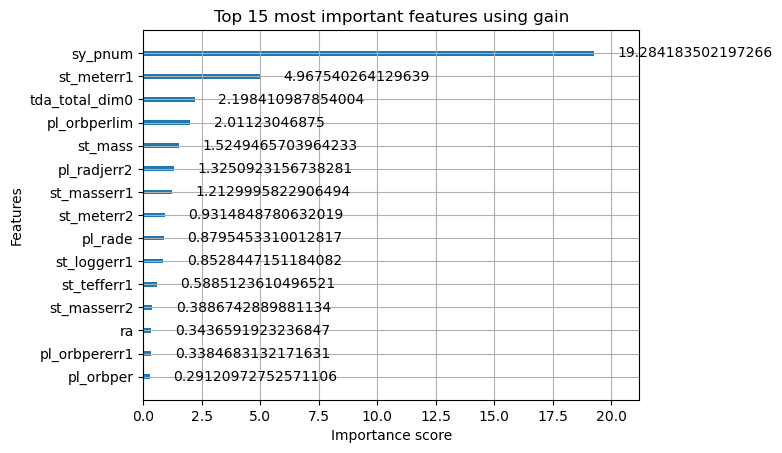

In [37]:
# Top 15 most important features using gain
plt.figure(figsize=(10,6))
plot_importance(best_model, max_num_features=15,importance_type="gain")
plt.title("Top 15 most important features using gain")
plt.show()

### Save the Model

In [39]:
import joblib

In [40]:
joblib.dump(best_model, "k2_model.pkl")

['k2_model.pkl']